In [1]:
import pymongo as pmg
import pandas as pd
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from matplotlib.lines import TICKLEFT, TICKRIGHT, Line2D
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.dates as mdate
from datetime import time
from KRData.HKData import HKFuture
import talib as tb
import configparser
from kline import Kline


conf_parser = configparser.ConfigParser()
conf_parser.read( 'conf.ini')
mg_host = conf_parser.get('MGDB', 'host')
mg_user = conf_parser.get('MGDB', 'user')
mg_password = conf_parser.get('MGDB', 'password')
# hf=HKFuture(pwd=mg_password,host=mg_host,user=mg_user)
hf=HKFuture()
begin='2011-01-01'
dt1=dt.datetime.now()
_fields = ['datetime', 'code', 'open', 'high', 'low', 'close', 'vol','trade_date']
df=hf.get_bars('HSI1201',_fields)
df.head()

OK


,datetime,code,open,high,low,close,trade_date
datetime,,,,,,,
2011-11-30 09:15:00,2011-11-30 09:15:00,HSI1201,18157.0,18157.0,18113.0,18113.0,2011-11-30
2011-11-30 09:17:00,2011-11-30 09:17:00,HSI1201,18131.0,18131.0,18130.0,18130.0,2011-11-30
2011-11-30 09:19:00,2011-11-30 09:19:00,HSI1201,18140.0,18140.0,18140.0,18140.0,2011-11-30
2011-11-30 09:21:00,2011-11-30 09:21:00,HSI1201,18127.0,18127.0,18115.0,18115.0,2011-11-30
2011-11-30 09:28:00,2011-11-30 09:28:00,HSI1201,18107.0,18107.0,18107.0,18107.0,2011-11-30


In [3]:
from bt_base import BT_Calc
class BT_Trade(BT_Calc):
#初始化---------------------------------------------------------------------------------
    def __init__(self,hf:HKFuture,index='HSI',**arg):
        self.hf=hf
        self._DateList=hf.get_main_contract_trade_dates(index)
        self.Test_Trade=True
        self.std_base=2.5
        self.cls()
        self.trade_para()
        print("---init-----")
#交易参数---------------------------------------------------------------
    def trade_para(self):
        pass
#每个交易日每条记录循环部分(只计算)---------------------------------------------------------
    def day_loop(self):
        self.day_calc_init()
        self.day_trade_init()
        df=self._para['df1']
        self._para['day_no']=0
        for i,row in df.iterrows():
            self._para['row']=row
            self.day_calc_main()
            self.day_trade_main()
            self._para['day_no']+=1
        self.day_calc_end()
        self.day_trade_end()

#每个交易日交易前初始化--------------------------------------------------------------------------
    def day_trade_init(self):
        pass

#每个交易日交易计算主体--------------------------------------------------------------------------
    def day_trade_main(self):
        pass

#每个交易日交易每天结束--------------------------------------------------------------------------
    def day_trade_end(self):
        pass
    
print("BT_Trade")

BT_Trade


In [53]:
class BT_Trade_STD(BT_Trade):
#交易参数---------------------------------------------------------------
    def trade_para(self):
        self._para['trade_state']='ready'
        
#每个交易日交易前初始化--------------------------------------------------------------------------
    def day_trade_init(self):
        self._para['trade_state']='ready'
        self.trade={}
        
#每个交易日交易计算主体--------------------------------------------------------------------------
    def day_trade_main(self):
        if self._para['trade_state']=='ready':
            self.day_trade_open()
        elif self._para['trade_state']=='open':
             self.day_trade_close()
#开仓条件--------------------------------------------------------------------------
    def day_trade_open(self):
        if len(self._res['std'])==0:
            return
        row=self._para['row']
        std=self._res['std'][-1]
        if row['std1']<-2.5 and std['ma60_no']>1 and std['ma60_state']=='over':
            trade={}
            trade['open']=row['close']
            trade['open_idx']=self._para['day_no']
            trade['open_dt']=row['datetime']
            trade['prod']=self._para['prod']
            trade['date']=self._para['date']
            trade['state']='short'
            self.trade=trade
            self._para['trade_state']='open'
            
#平仓仓条件--------------------------------------------------------------------------
    def day_trade_close(self):
        if self._para['ma60']['no']==1:
            row=self._para['row']
            self.trade['close']=row['close']
            self.trade['close_idx']=self._para['day_no']
            self.trade['close_dt']=row['datetime']
            self._para['trade_state']='ready'
            self._res['trade'].append(self.trade)
print("Done")

Done


In [54]:
import time
t1=time.time()
bt1=BT_Trade_STD(hf)
bt1.contract_all()
t2=time.time()
print(t2-t1)
t1=pd.DataFrame(bt1._res['trade'])
t1.head()

---init-----
229.48112559318542


,close,close_dt,close_idx,date,open,open_dt,open_idx,prod,state
0,23895.0,2011-02-02 12:17:00,152,2011-02-02,23823.0,2011-02-02 10:18:00,33,HSI1102,short
1,22307.0,2011-03-18 09:44:00,29,2011-03-18,22333.0,2011-03-18 09:33:00,18,HSI1103,short
2,23402.0,2011-03-30 14:09:00,203,2011-03-30,23416.0,2011-03-30 11:57:00,162,HSI1103,short
3,24143.0,2011-04-21 11:28:00,133,2011-04-21,24165.0,2011-04-21 11:02:00,107,HSI1104,short
4,22811.0,2011-07-04 11:56:00,161,2011-07-04,22800.0,2011-07-04 09:30:00,15,HSI1107,short


In [62]:
trades=[]
for i,row in t1.iterrows():
    trade={}
    trade['open']={}
    trade['close']={}
    trade['open']['datetime']=str(row['open_dt'])
    trade['open']['price']=row['open']
    trade['open']['size']=1
    trade['open']['direction']='short'
    trade['close']['datetime']=str(row['close_dt'])
    trade['close']['price']=row['close']
    trade['close']['size']=1
    trade['close']['direction']='long'
    trades.append(trade)
    
pd.to_pickle(trades,"pkl/trades.pkl")

In [66]:
t1['diff']=t1.open-t1.close
t1['diff'].agg(['sum','count','mean'])
tools.GetROI(t1)

{'ALL_Profit': 2068.0,
 'All_CNT': 442.0,
 'All_Mean': 4.678733031674208,
 'Win_Sum': 11256.0,
 'Win_CNT': 310.0,
 'Win_Mean': 36.30967741935484,
 'Win_Max': 212.0,
 'Win_Min': 1.0,
 'Lose_Sum': -9188.0,
 'Lose_CNT': 130.0,
 'Lose_Mean': -70.67692307692307,
 'Lose_Max': -1.0,
 'Lose_Min': -400.0,
 'Win/Lose': 0.513741626525482,
 'Win%': 70.13574660633485,
 'ROI': 22.507618632999566}

In [29]:
# t1.to_pickle("pkl/t1.pkl")
# t1=pd.read_pickle("pkl/t1.pkl")
t1

,close,close_idx,date,open,open_idx,prod,diff
0,23967.0,98,2011-01-25,23975.0,53,HSI1101,-8.0
1,23895.0,152,2011-02-02,23839.0,30,HSI1102,56.0
2,22910.0,64,2011-02-14,22968.0,36,HSI1102,-58.0
3,23287.0,31,2011-02-18,23323.0,16,HSI1102,-36.0
4,23523.0,50,2011-02-18,23529.0,49,HSI1102,-6.0
5,22514.0,82,2011-03-21,22558.0,34,HSI1103,-44.0
6,23245.0,33,2011-03-28,23253.0,32,HSI1103,-8.0
7,23402.0,203,2011-03-30,23310.0,34,HSI1103,92.0
8,23649.0,60,2011-04-20,23718.0,30,HSI1104,-69.0
9,24143.0,133,2011-04-21,24109.0,67,HSI1104,34.0


In [8]:
tools.GetROI(t1)

{'ALL_Profit': 3306.0,
 'All_CNT': 307.0,
 'All_Mean': 10.768729641693811,
 'Win_Sum': 9181.0,
 'Win_CNT': 228.0,
 'Win_Mean': 40.26754385964912,
 'Win_Max': 203.0,
 'Win_Min': 1.0,
 'Lose_Sum': -5875.0,
 'Lose_CNT': 77.0,
 'Lose_Mean': -76.2987012987013,
 'Lose_Max': -2.0,
 'Lose_Min': -425.0,
 'Win/Lose': 0.5277618514371034,
 'Win%': 74.2671009771987,
 'ROI': 56.27234042553192}

In [18]:
ma60=pd.DataFrame(bt1._res['ma60'])
ma60.head()
ma60[ma60.date=='2011-10-07']

,begin,begin_idx,cnt,date,diff,end,end_idx,idx,no,prod,state
4515,17440.0,NaN,166,2011-10-07,244.0,17684.0,165,4515,0,HSI1110,over
4516,17684.0,165.0,55,2011-10-07,48.0,17636.0,220,4516,1,HSI1110,under
4517,17636.0,220.0,14,2011-10-07,-12.0,17624.0,234,4517,1,HSI1110,over
4518,17624.0,234.0,1,2011-10-07,-10.0,17634.0,235,4518,2,HSI1110,under
4519,17634.0,235.0,1,2011-10-07,-9.0,17625.0,236,4519,2,HSI1110,over
4520,17625.0,236.0,4,2011-10-07,-3.0,17628.0,240,4520,3,HSI1110,under
4521,17628.0,240.0,14,2011-10-07,20.0,17648.0,254,4521,3,HSI1110,over
4522,17648.0,254.0,31,2011-10-07,31.0,17617.0,285,4522,4,HSI1110,under
4523,17617.0,285.0,7,2011-10-07,-25.0,17592.0,292,4523,4,HSI1110,over
4524,17592.0,292.0,1,2011-10-07,-23.0,17615.0,293,4524,5,HSI1110,under


In [21]:
std=pd.DataFrame(bt1._res['std'])
std.head()
std[std.date=='2011-10-07']

,chg,close,date,day_no,idx,ma60_cnt,ma60_idx,ma60_no,ma60_state,macd_cnt,macd_idx,macd_no,macd_state,state,std
1407,33.0,17508.0,2011-10-07,19,1407,21,4515,0,over,21,2173,0,red,1,2.830710
1408,40.0,17615.0,2011-10-07,50,1408,52,4515,1,over,52,2173,1,red,1,2.761514
1409,39.0,17773.0,2011-10-07,146,1409,148,4515,2,over,22,2177,0,red,1,3.418733
1410,33.0,17614.0,2011-10-07,206,1410,42,4516,0,under,40,2178,0,green,1,2.597318
1411,53.0,17717.0,2011-10-07,244,1411,5,4521,0,over,25,2179,0,red,1,3.622980
1412,-44.0,17624.0,2011-10-07,316,1412,1,4526,0,under,31,2181,0,red,2,-2.560753


In [7]:
from  bt_base import tools

k=Kline()
def KL(prod,date,**para):
    #prod='HSI1901'
    #date='2019-01-14'
    _fields = ['datetime', 'code', 'open', 'high', 'low', 'close', 'vol','trade_date']
    df1=hf.get_bars(prod,_fields)
    df1['macd'],df1['diff'],df1['dea']=tb.MACD(df1.close.values,fastperiod=12,slowperiod=26,signalperiod=9)
    df1['ma30']=tb.EMA(df1.close.values,timeperiod=30)
    df1['ma60']=tb.EMA(df1.close.values,timeperiod=60)
    t1=dt.time(9,15,0)
    t2=dt.time(16,30,0)
    a2=df1[df1.datetime.apply(lambda x:t1<=x.time()<=t2)]
    k.DrawKline(a2[a2.trade_date==date],**para)

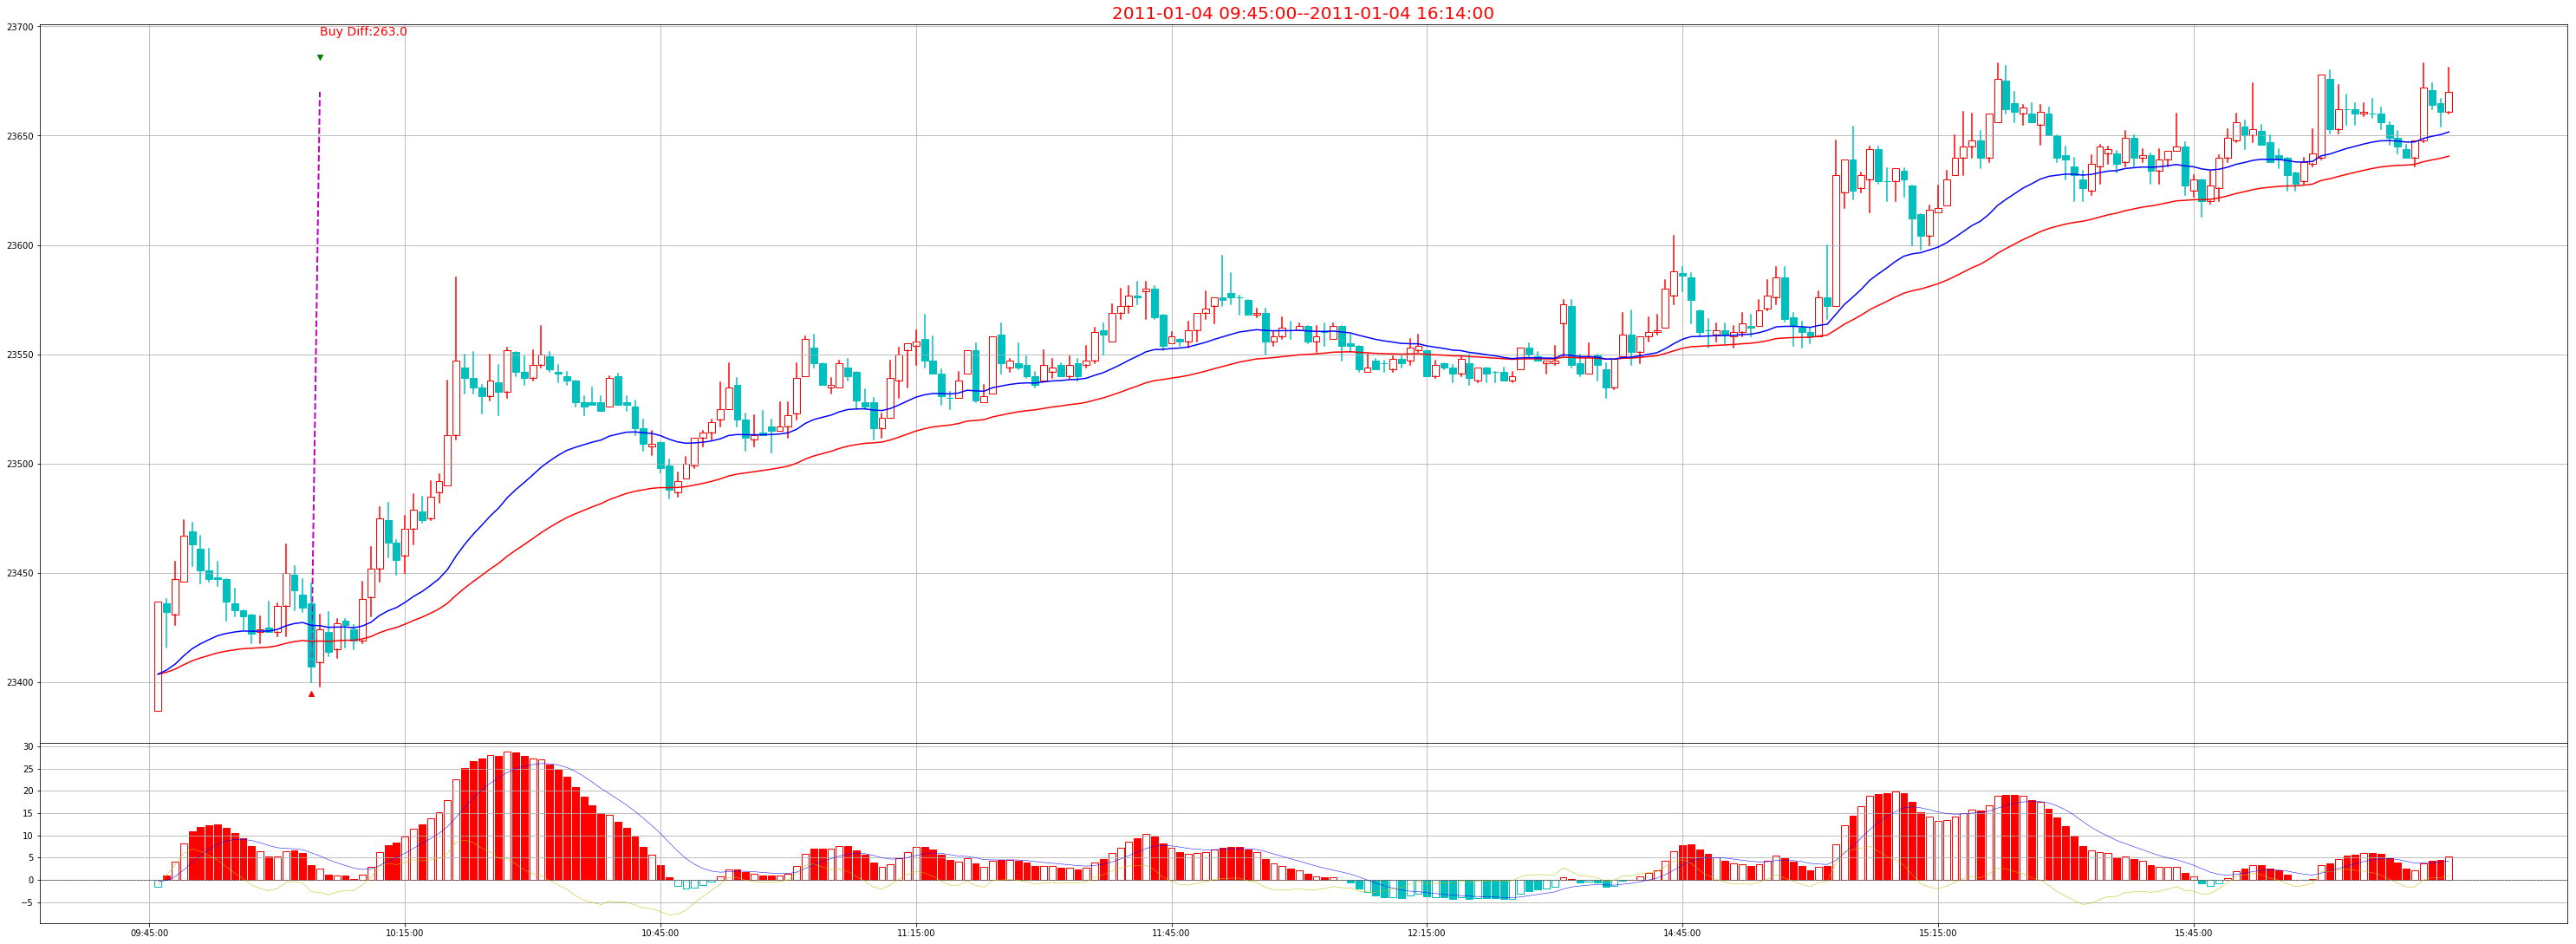

In [4]:
KL('HSI1101','2011-01-04',trade=('buy',18,19))

HSI1801 2018-01-02 img/std2_2018-01-02_330_a400.0.jpg 14 219


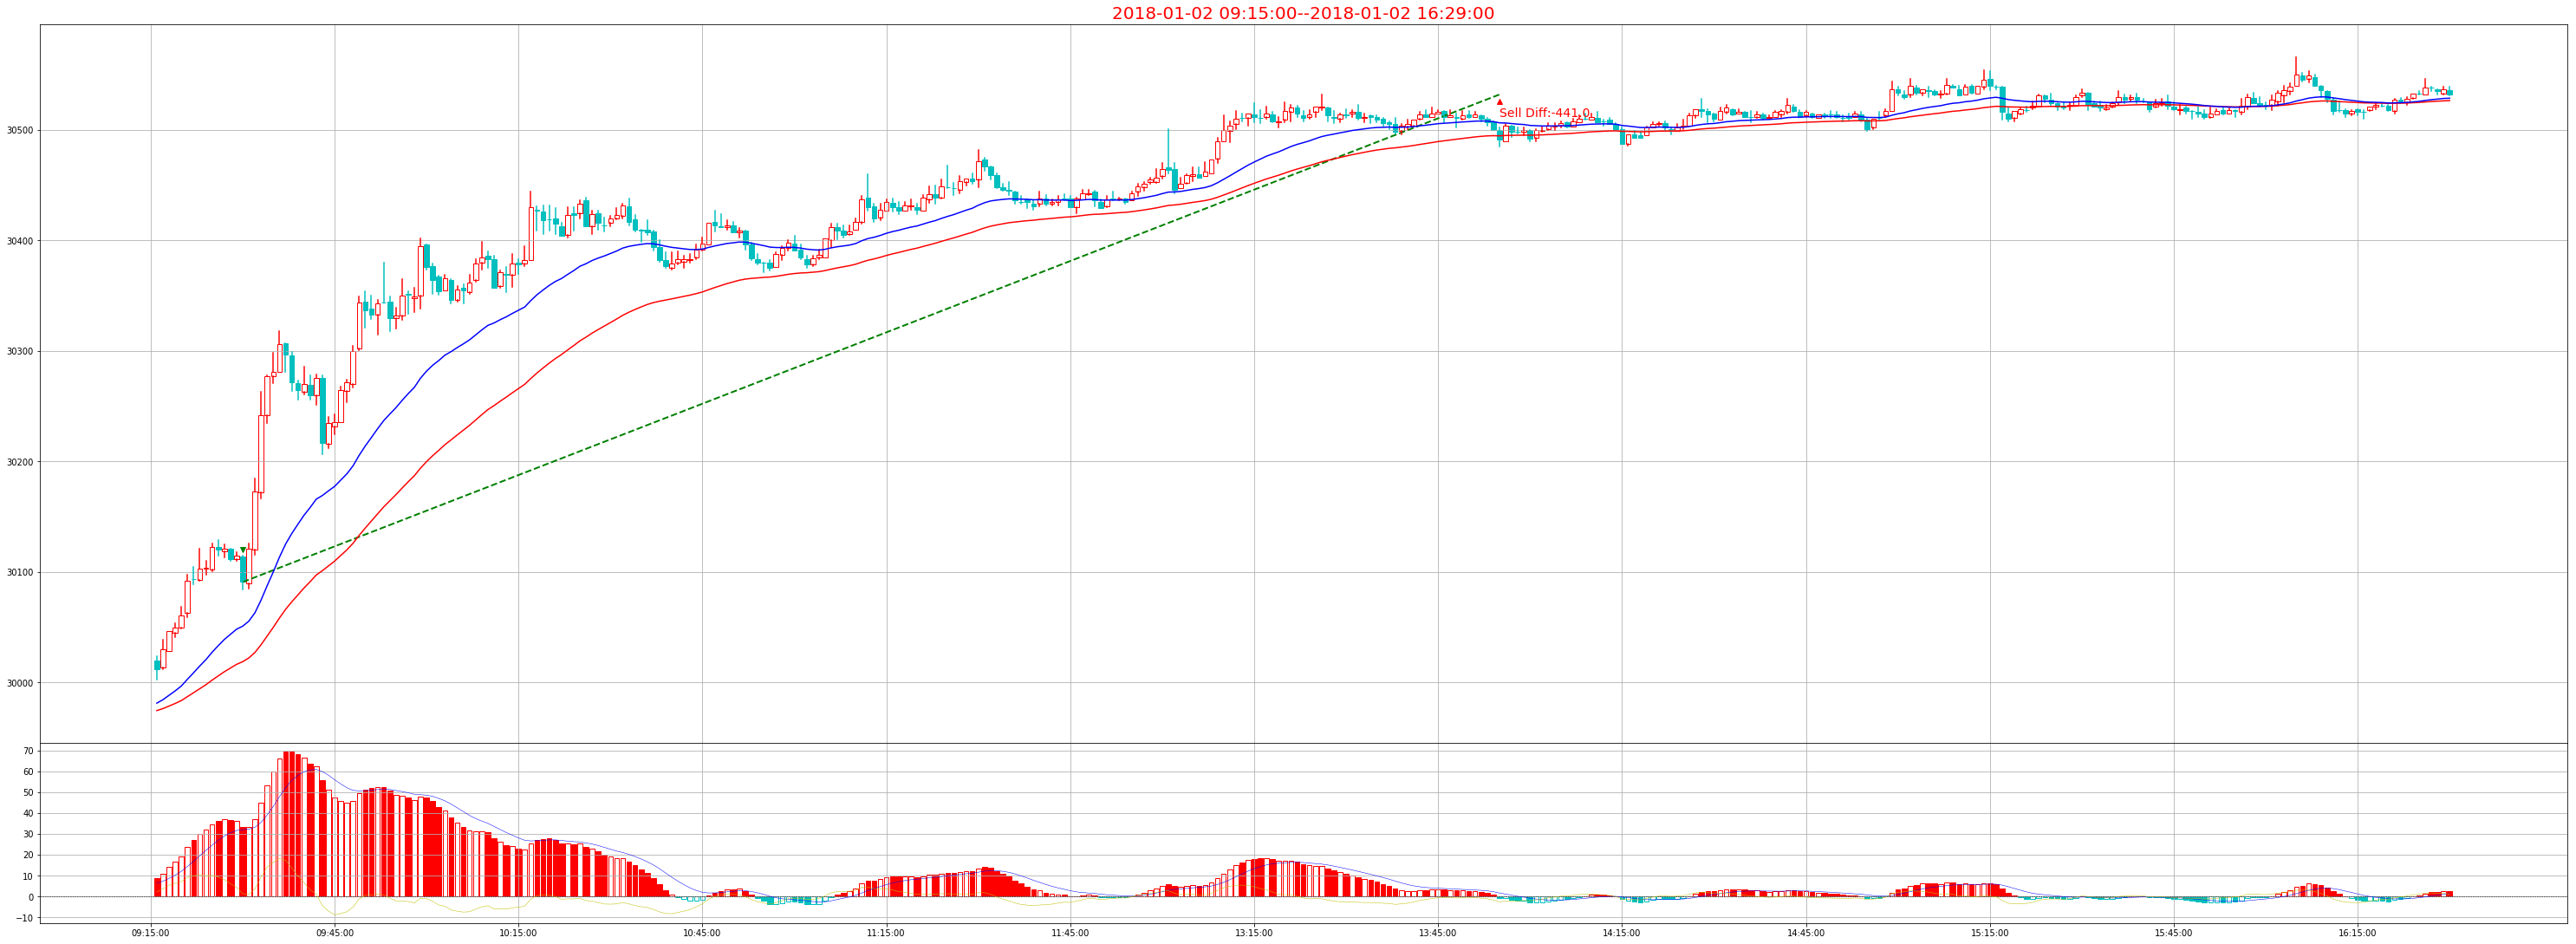

HSI1707 2017-07-11 img/std2_2017-07-11_294_a327.0.jpg 10 259


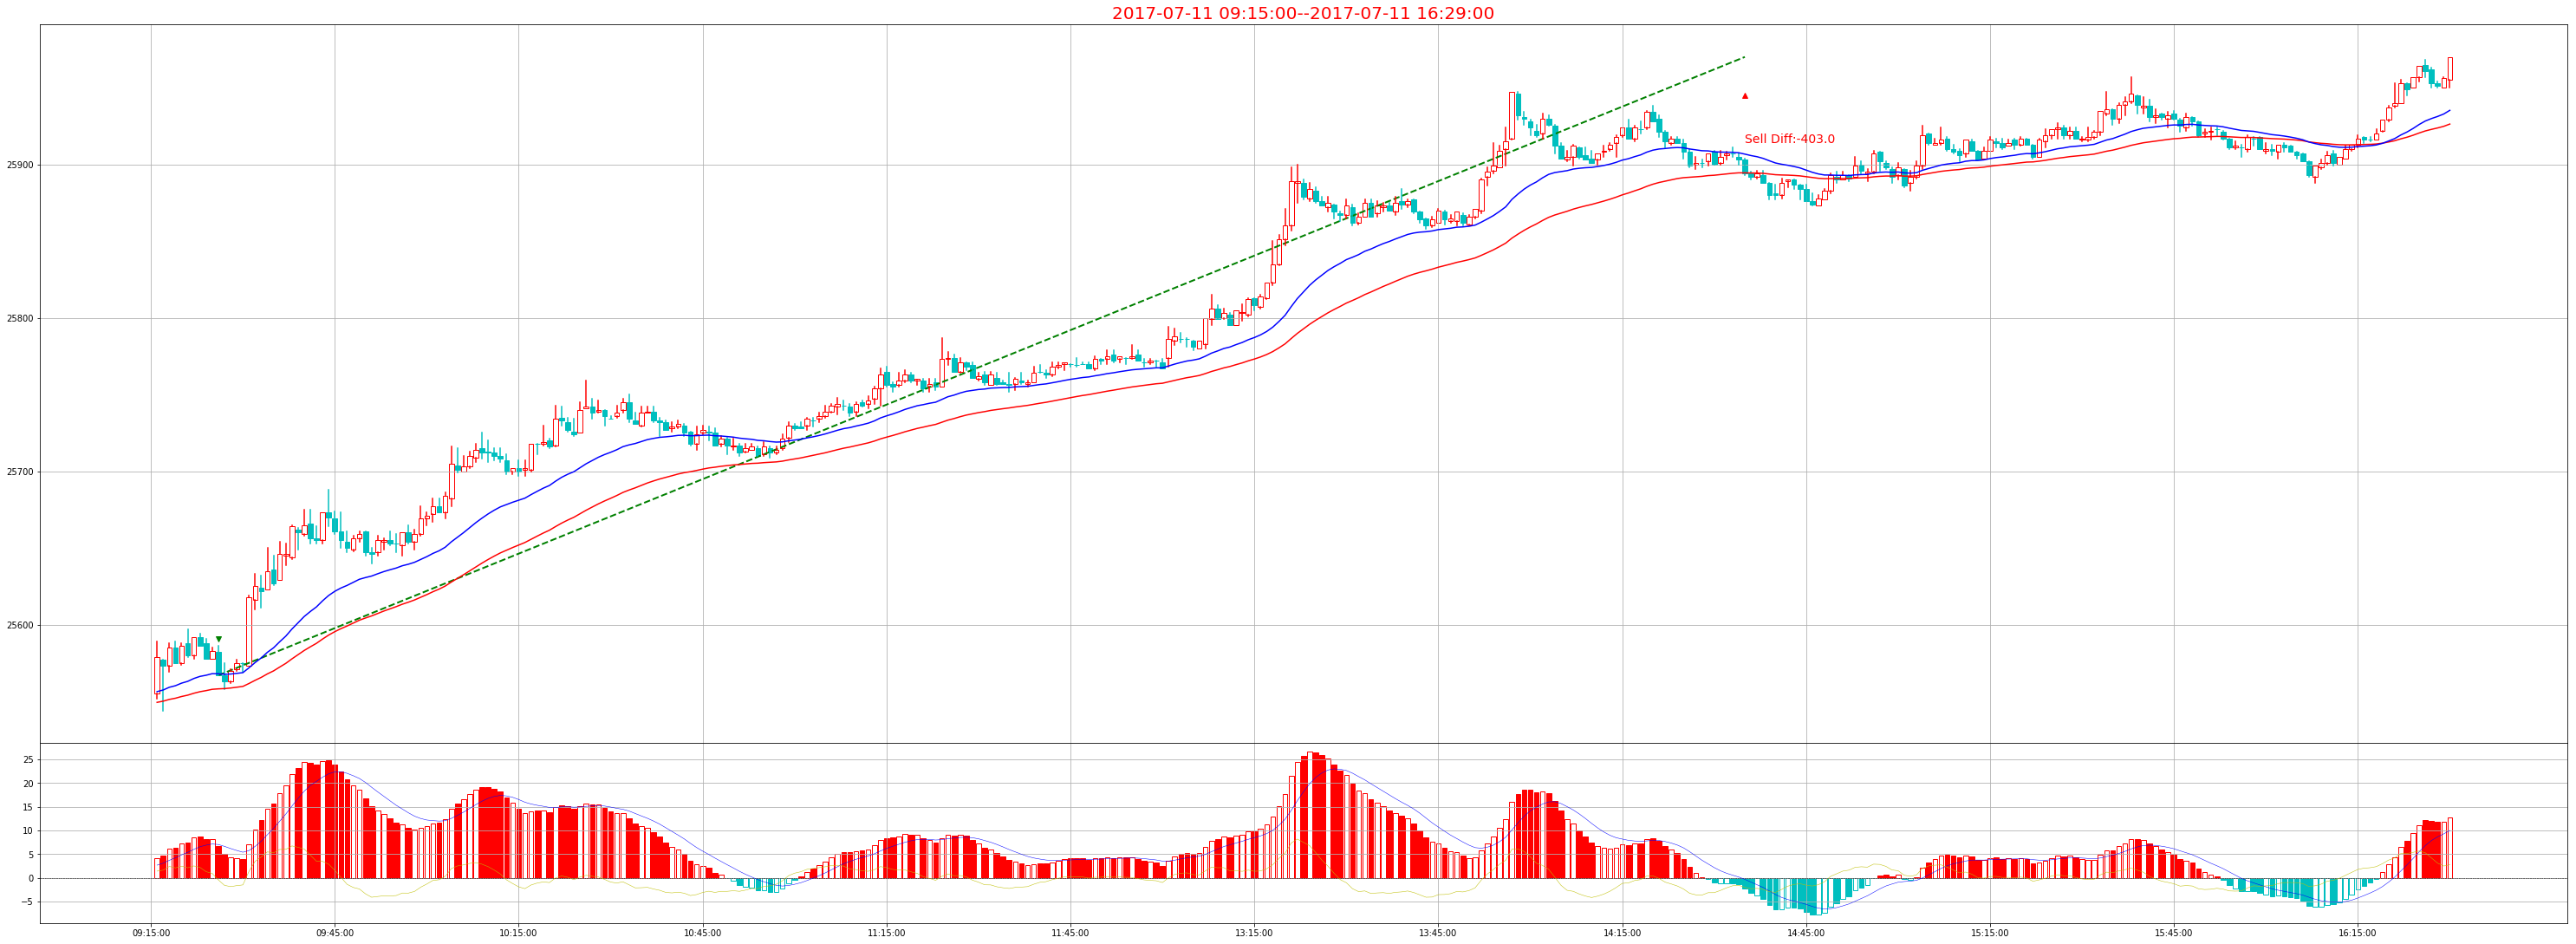

HSI1307 2013-07-23 img/std2_2013-07-23_48_a314.0.jpg 14 196


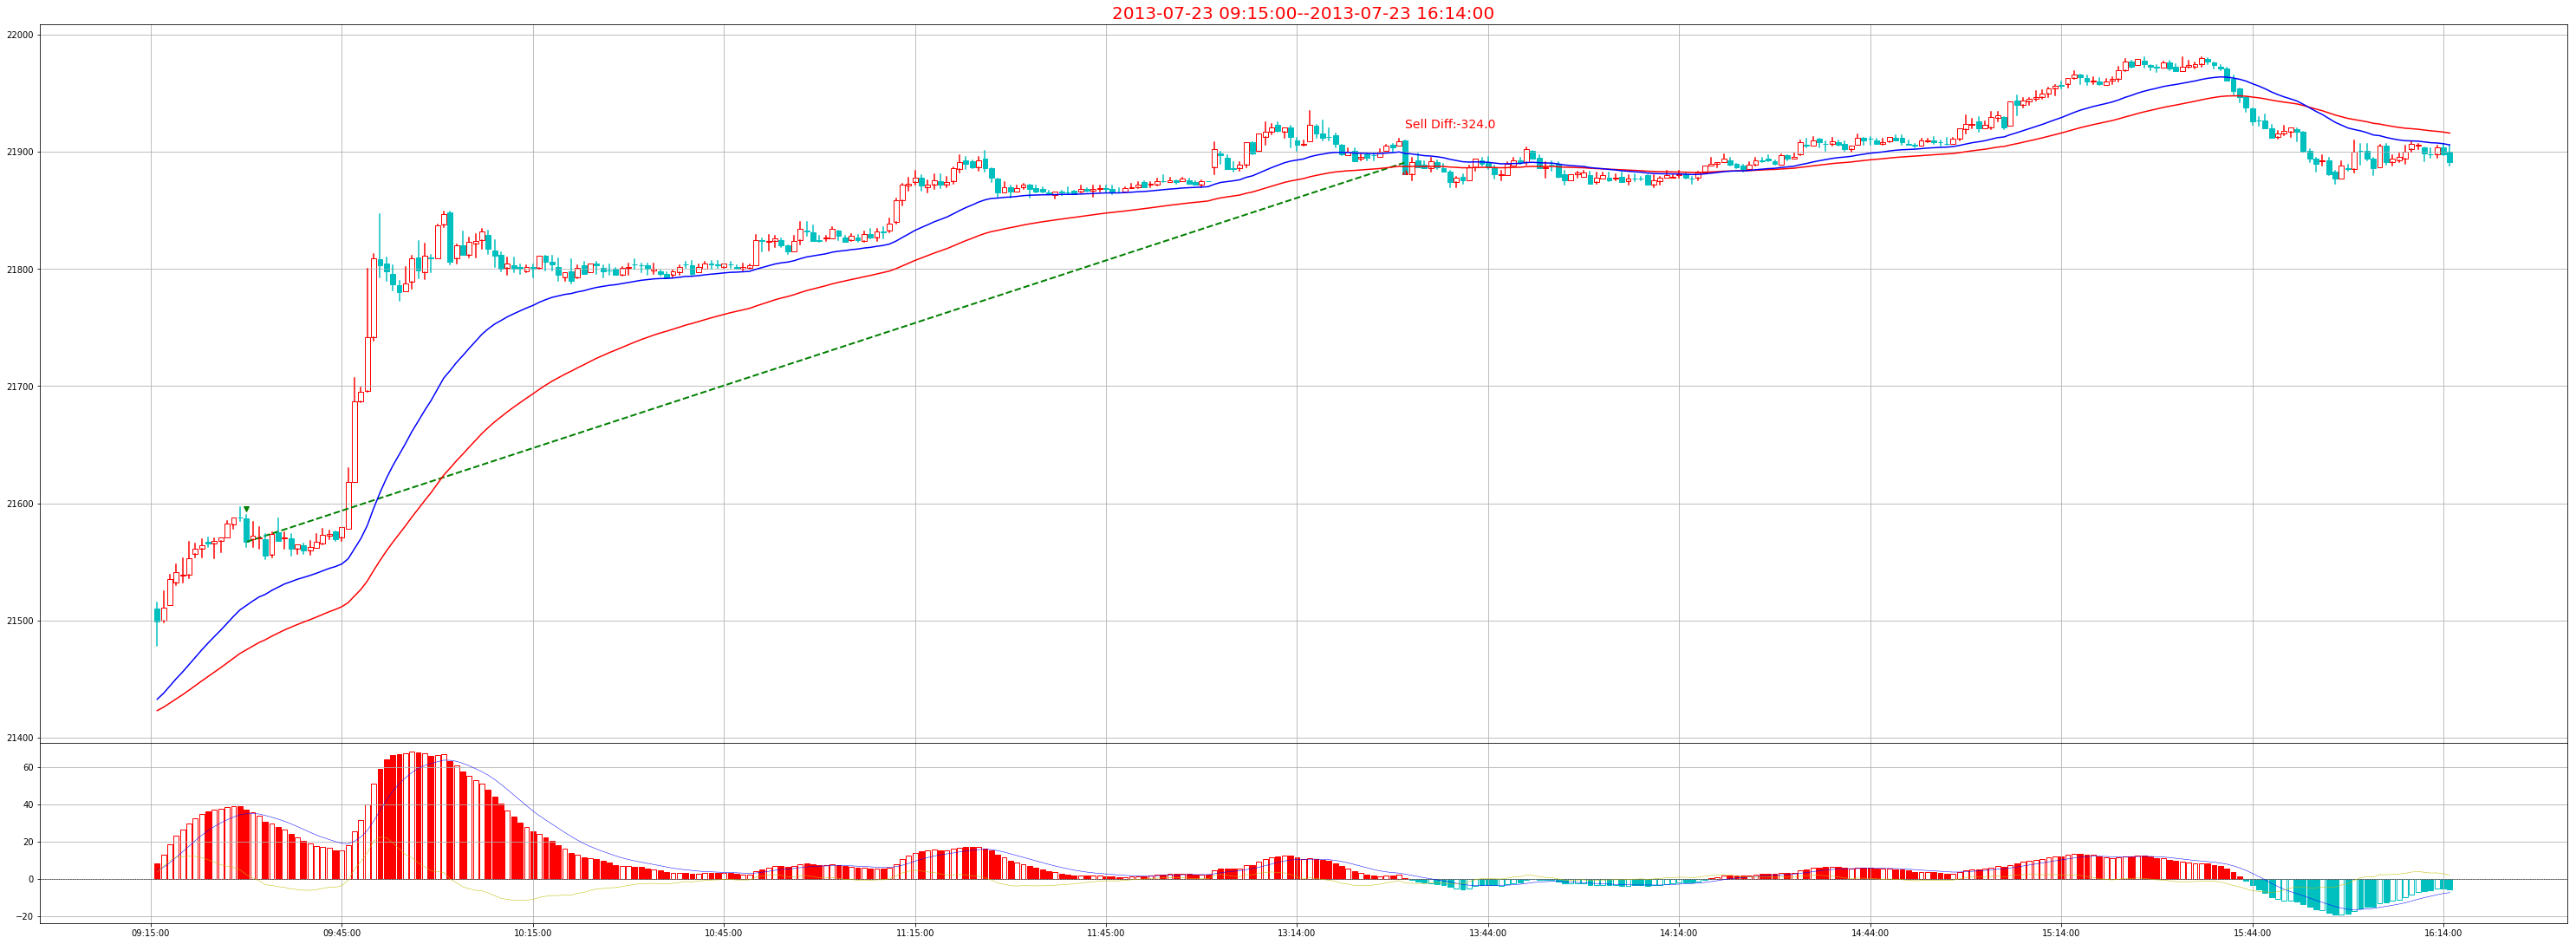

HSI1801 2018-01-16 img/std2_2018-01-16_335_a313.0.jpg 4 175


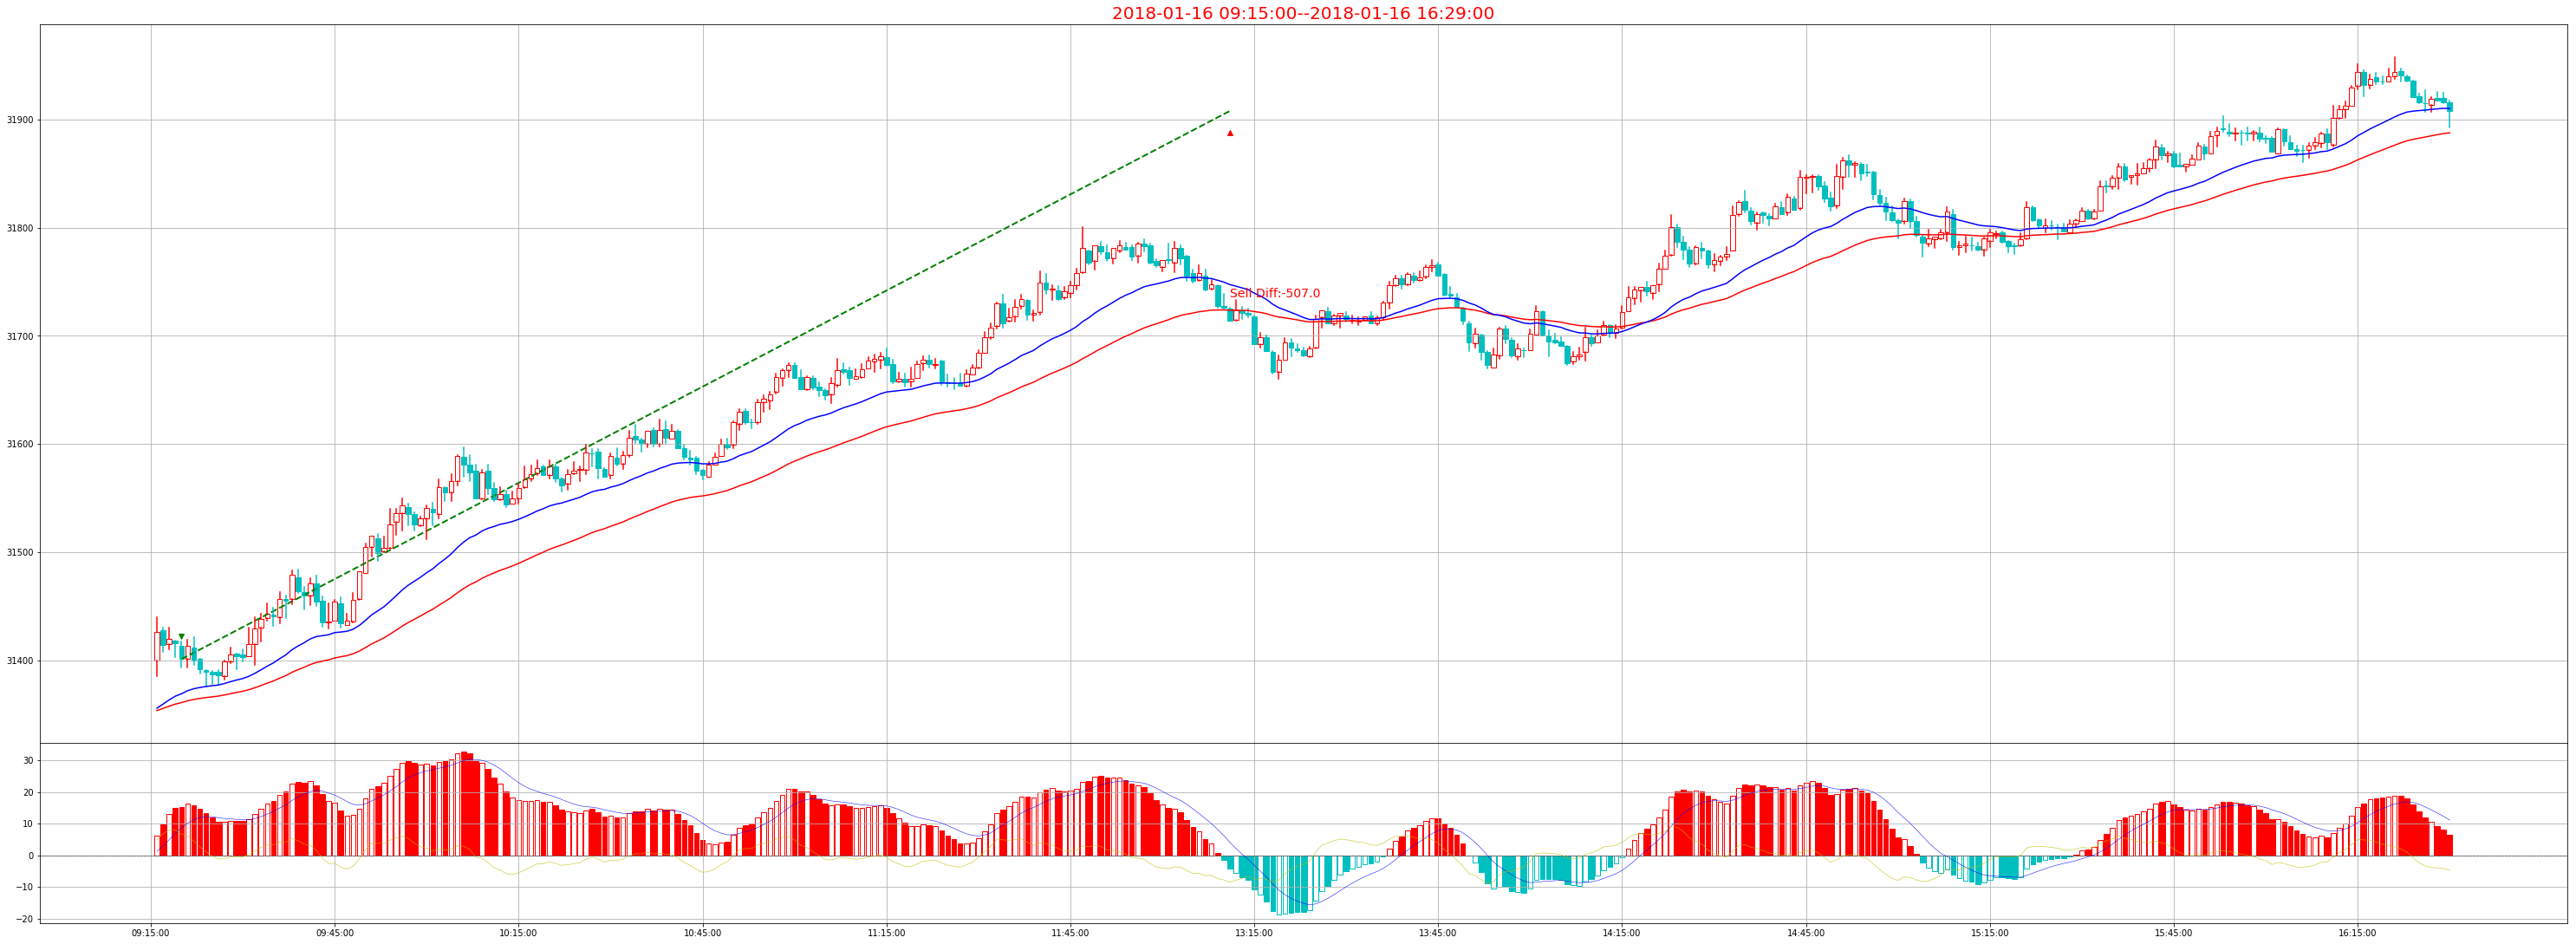

HSI1407 2014-07-22 img/std2_2014-07-22_106_a299.0.jpg 17 207


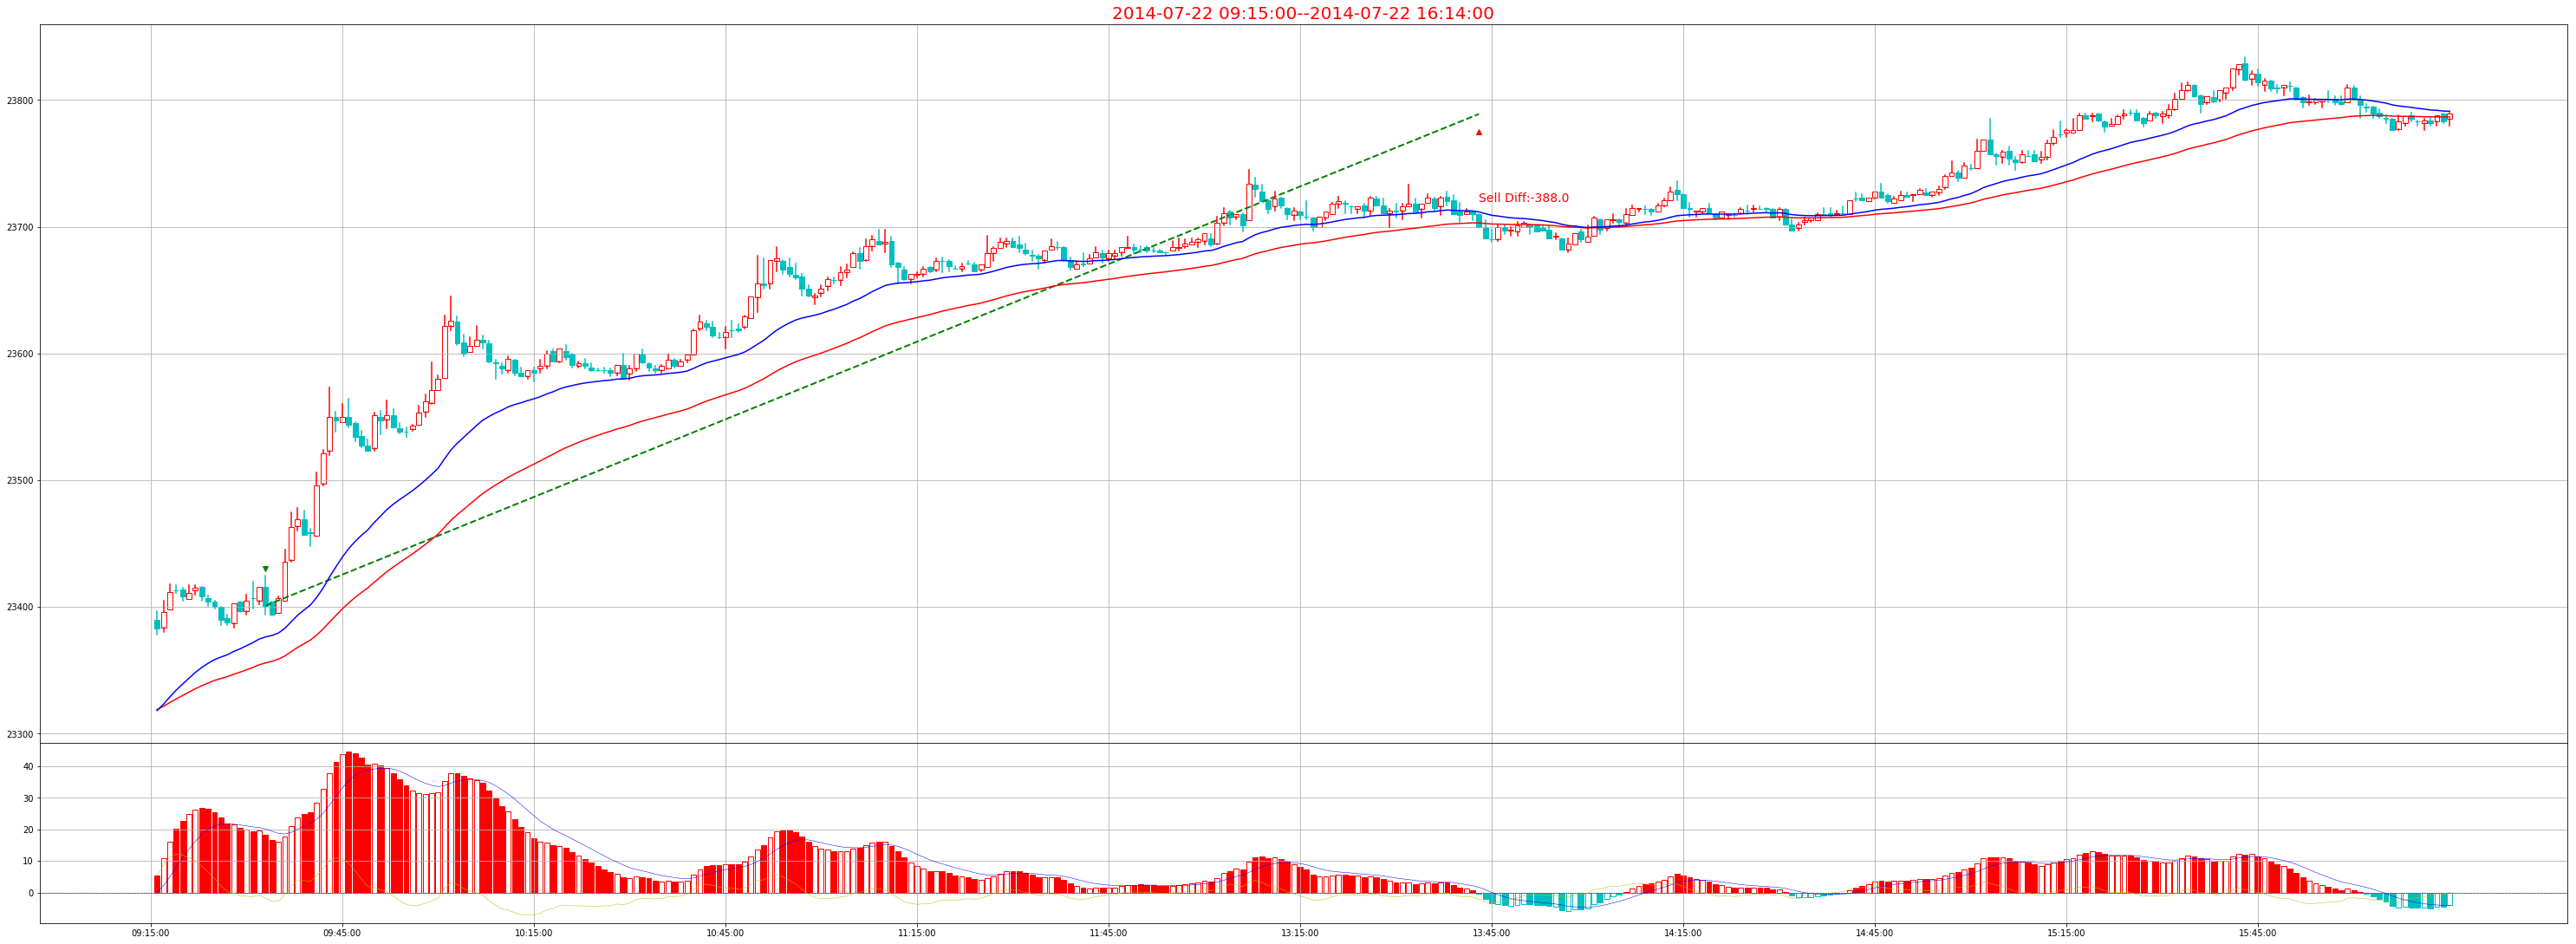

In [70]:
#2011-10-07 20170406
for i ,row in t1.sort_values('diff').head(5).iterrows():
    prod=row['prod']
    date=str(row['date'].date())
    day_no=row['open_idx']
    end_idx=row['close_idx']
    chg=row['diff']
    if chg>0:
        file="img/std2_%s_%d_%s.jpg" %(date,i,chg)
    else:
        file="img/std2_%s_%d_a%s.jpg" %(date,i,-chg)
    print(prod,date,file,day_no,end_idx)
    KL(prod,date,trade=['sell',day_no,end_idx])
